# Carbon comparison
Peter Attia, April 18 2020

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.legend_handler import HandlerBase

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Load graphite data

In [3]:
df_graphite = pd.read_excel('A123 graphite coin cell.xlsx', sheet_name='Channel_Normal_Table')
df_graphite.head()

,Test_ID,Data_Point,Test_Time,Step_Time,DateTime,Step_Index,Cycle_Index,Is_FC_Data,Current,Voltage,Charge_Capacity,Discharge_Capacity,Charge_Energy,Discharge_Energy,dV/dt,Internal_Resistance,AC_Impedance,ACI_Phase_Angle
0,1,1,0.060000,0.000002,42625.929688,1,1,0,-0.000323,1.980894,0.0,2.110000e-13,0.0,4.170000e-13,0.000000,0,0,0
1,1,2,0.079868,0.019871,42625.929688,1,1,0,-0.000328,1.952418,0.0,1.797707e-09,0.0,3.535473e-09,-0.005695,0,0,0
2,1,3,0.119877,0.059880,42625.929688,1,1,0,-0.000328,1.942858,0.0,5.444511e-09,0.0,1.064682e-08,-0.007607,0,0,0
3,1,4,0.159786,0.099789,42625.929688,1,1,0,-0.000328,1.934722,0.0,9.082147e-09,0.0,1.770694e-08,-0.009234,0,0,0
4,1,5,0.199842,0.139845,42625.929688,1,1,0,-0.000328,1.926789,0.0,1.273323e-08,0.0,2.476356e-08,-0.010821,0,0,0


Normalize capacities:

In [4]:
mass = 8.483 / 1000 # mg -> g
df_graphite.Charge_Capacity = df_graphite.Charge_Capacity / mass * 1000 # Ah -> mAh/g
df_graphite.Discharge_Capacity = df_graphite.Discharge_Capacity / mass * 1000 # Ah -> mAh/g

Drop all but first 5 rows:

In [5]:
df_graphite = df_graphite[df_graphite['Cycle_Index'] < 6]

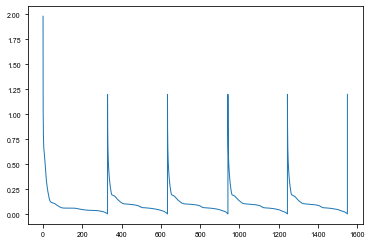

In [6]:
plt.plot(df_graphite['Discharge_Capacity'], df_graphite['Voltage'])

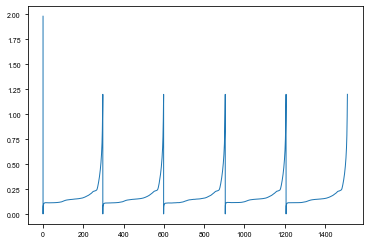

In [7]:
plt.plot(df_graphite['Charge_Capacity'], df_graphite['Voltage'])

## Load carbon black data
I can't find the original data with cycle/step indices unfortunately, but I do have a `.mat` file from back in the day

In [8]:
data_CB = sio.loadmat('carbon black.mat')
Q_CB = data_CB['Q'][0]
V_CB = data_CB['V'][0]

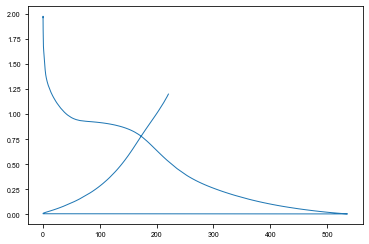

In [9]:
plt.plot(Q_CB[0], V_CB[0])

## Create plot

Helper function for legend with multiple lines per entry [here](https://stackoverflow.com/questions/41752309/single-legend-item-with-two-lines)

In [10]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in t

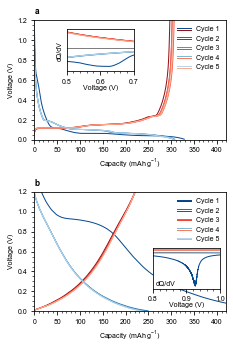

In [11]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height*2), nrows=2, ncols=1)

# Set main axes labels
ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ax[0].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[1].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')
ax[0].set_xlim([0, 420])
ax[1].set_xlim([0, 420])
ax[0].set_ylim([0, 1.2])
ax[1].set_ylim([0, 1.2])
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

# Create and set inset properties
ax_inset0 = inset_axes(ax[0], width='100%', height='100%',
                       bbox_to_anchor=(0.15, 0.6, 0.35, 0.35),
                       bbox_transform=ax[0].transAxes,
                       loc='upper left')
ax_inset1 = inset_axes(ax[1], width='100%', height='100%',
                       bbox_to_anchor=(0.6, 0.22, 0.35, 0.34),
                       bbox_transform=ax[1].transAxes,
                       loc='upper left')
ax_inset0.set_xlabel('Voltage (V)', labelpad=-0.1)
ax_inset1.set_xlabel('Voltage (V)', labelpad=0)
ax_inset0.set_ylabel('dQ/dV')
ax_inset1.annotate('dQ/dV', (0.05, 0.05), xycoords='axes fraction',
                   horizontalalignment='left', verticalalignment='bottom')
ax_inset0.set_xlim([0.5, 0.7])
ax_inset1.set_xlim([0.8, 1.0])
ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset1.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset0.set_ylim([-60, 50])
ax_inset1.set_ylim([-2400, 250])
ax_inset0.get_yaxis().set_ticks([])
ax_inset1.get_yaxis().set_ticks([])
ax_inset0.axhline(0, color='tab:gray')
ax_inset1.axhline(0, color='tab:gray')

## Graphite

colors_blue = cm.Blues(np.linspace(0.9, 0.3, 5))[:,0:3]
colors_red  = cm.Reds( np.linspace(0.9, 0.3, 5))[:,0:3]

for k, (cycle_num, group) in enumerate(df_graphite.groupby('Cycle_Index')):
    
    for step, subgroup in group.groupby('Step_Index'):
    
        # Get Q and V
        capacity_type = 'Discharge_Capacity' if step == 1 else 'Charge_Capacity'
        Q = subgroup[capacity_type] - subgroup[capacity_type].iloc[0]
        V = subgroup['Voltage']
    
        # Filter
        Q_filt = savgol_filter(Q, 11, 1)
        V_filt = savgol_filter(V, 11, 1)

        dQdV = np.gradient(Q_filt, V_filt)
        
        color = colors_blue[k] if step == 1 else colors_red[k]
    
        ax[0].plot(Q, V, color=color)
        ax_inset0.plot(V_filt, dQdV, color=color)

ax[0].legend([(colors_blue[0], colors_red[0]),
            (colors_blue[1], colors_red[1]),
            (colors_blue[2], colors_red[2]),
            (colors_blue[3], colors_red[3]),
            (colors_blue[4], colors_red[4])],
            ['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5'],
            handler_map={tuple: AnyObjectHandler()},
            loc='upper right')


## Carbon black

for k in np.arange(5):
    
    Q = Q_CB[k]
    V = V_CB[k]
    
    # Middle index
    idx = 50 + np.where(Q[50:] == np.min(Q[50:]))[0][0]
        
    # Get Q and V
    if k == 0:
        start_idx = np.where(Q == 0)[0][-1]
    else:
        start_idx = 0
    
    Q_lith = Q[start_idx:idx].flatten()
    V_lith = V[start_idx:idx].flatten()
    Q_delith = Q[idx:].flatten()
    V_delith = V[idx:].flatten()
        
    # Filter
    Q_filt_lith = savgol_filter(Q_lith, 301, 3)
    V_filt_lith = savgol_filter(V_lith, 301, 3)
    Q_filt_delith = savgol_filter(Q_delith, 105, 3)
    V_filt_delith = savgol_filter(V_delith, 105, 3)
        
    # dQ/dV
    dQdV_lith = np.gradient(Q_filt_lith, V_filt_lith)
    dQdV_delith = np.gradient(Q_filt_delith, V_filt_delith)
    
    ax[1].plot(Q_lith, V_lith, color=colors_blue[k])
    ax[1].plot(Q_delith, V_delith, color=colors_red[k])
    ax_inset1.plot(V_filt_lith, dQdV_lith, color=colors_blue[k])
    ax_inset1.plot(V_filt_delith, dQdV_delith, color=colors_red[k])
    
ax[1].legend([(colors_blue[0], colors_red[0]),
            (colors_blue[1], colors_red[1]),
            (colors_blue[2], colors_red[2]),
            (colors_blue[3], colors_red[3]),
            (colors_blue[4], colors_red[4])],
            ['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5'],
            handler_map={tuple: AnyObjectHandler()},
            loc='upper right')

plt.tight_layout()
plt.savefig(figpath / 'carbon_comparison.eps', bbox_inches='tight', format='eps')